In [846]:
%matplotlib inline

import re
import json
import time
import random
import os.path
import requests
import warnings
import powerlaw
import itertools
import urllib.parse
import urllib.request

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

from datetime import datetime
from sklearn import preprocessing

plt.style.use(["seaborn-whitegrid"])
plt.rcParams["figure.figsize"] = (10, 5)

#print(plt.style.available)

In [847]:
#Read in the symbol title dataframe
symbol_title = pd.read_csv("symbol_title.csv", index_col=2, sep=",")
symbol_title = symbol_title[["symbol","sector","industry"]]
symbol_title.dropna(inplace=True)
symbol_title.head(10)

,symbol,sector,industry
name,,,
AAC Holdings,AAC,Conglomerates,Conglomerates
Almaden Minerals Ltd.,AAU,Basic Materials,Industrial Metals & Minerals
American Biltrite Inc.,ABL,Consumer Goods,Rubber & Plastics
Acme United Corp.,ACU,Consumer Goods,Office Supplies
AeroCentury Corp.,ACY,Services,Rental & Leasing Services
Allied Defense Group Inc.,ADGI,Industrial Goods,Aerospace/Defense Products & Services
AdCare Health Systems Inc.,ADK,Healthcare,Long-Term Care Facilities
Adams Resources & Energy Inc.,AE,Basic Materials,Major Integrated Oil & Gas
"Adeona Pharmaceuticals, Inc.",AEN,Healthcare,Biotechnology


In [848]:
security = pd.read_csv("security.csv", encoding="utf8")

In [849]:
#Allows an application to request user authorization. 
def oauth_authorize():    
    url = "https://api.stocktwits.com/api/2/oauth/authorize"                
    params = urllib.parse.urlencode({"client_id": security["client_id"][0], 
                                     "response_type": "token",
                                     "redirect_uri": "https://sites.google.com/site/noelnamai/",
                                     "scope": "read,watch_lists,publish_messages,publish_watch_lists,follow_users,follow_stocks"
                                    })    
    oauth = urllib.request.urlopen(url, params.encode("UTF-8"))    
    return oauth

In [850]:
oauth = oauth_authorize()

In [851]:
#Returns the most recent 30 messages for the specified symbol. Includes symbol object in response.
def stream_symbol(symbol):
    url = "https://api.stocktwits.com/api/2/streams/symbol/" + str(symbol) + ".json"
    try:
        content = requests.get(url).json()
    except Exception as error:
        raise Exception("Method: stream_symbol. Error: " + str(error))
    return content

In [852]:
#Returns the most recent 30 messages with trending symbols in the last 5 minutes.
def stream_trending():             
    url = "https://api.stocktwits.com/api/2/streams/trending.json"
    payload = {"access_token": security["access_token"][0]}
    try:    
        content = requests.get(url, params=payload).json()
    except Exception as error:
        raise Exception("Method: stream_trending. Error: " + str(error))
    return content

In [853]:
#Returns the most recent 30 symbols in the last 5 minutes.
def get_symbols():
    symbols = []
    data = stream_trending()
    code = data["response"]["status"] 
    for tweet in data["messages"]:
        for symbol in tweet["symbols"]:
            symbols.append(symbol["symbol"])
    return code, symbols

In [854]:
#Creates a dataframe from JSON data returned by the API.
def create_dataframe(data): 
    response = [] 
    code = data["response"]["status"]                                  
    if code == 200: 
        for tweet in data["messages"]:
            for symbol in tweet["symbols"]:
                utc = datetime.strptime(tweet["created_at"], "%Y-%m-%dT%H:%M:%SZ")
                row = {"symbol": symbol["symbol"],
                       "title": symbol["title"],
                       "tweet_id": tweet["id"],
                       "text": tweet["body"],
                       "date": str(utc.date()),
                       "time": str(utc.time()),
                       "weekday": utc.weekday(),
                       "name": tweet["user"]["name"],
                       "user_id": str(tweet["user"]["id"]),
                       "user_name": str(tweet["user"]["username"])}
                response.append(row) 
    else: 
        raise Exception("Method: create_dataframe " + "Error: " + str(data["errors"][0]["message"]))
    df = pd.DataFrame(response)
    return code, df

In [855]:
#Clean the data frame and fill in the missing data
def clean_dataframe(df):
    df = df.drop_duplicates()    
    df = df.dropna() 
    df["weekday"] = df["weekday"].astype("int")
    df["tweet_id"] = df["tweet_id"].astype("int")
    df.sort_values(["tweet_id","time"], ascending=True, inplace=True)
    df["index"] = range(len(df))
    df = df.set_index("index")
    return df

In [856]:
#Fill in the data "sector" and "industry" to the main dataframe.
def fill_dataframe(x):   
    symbol = list(set(x["symbol"].values))[0]
    sector = symbol_title["sector"][symbol_title["symbol"] == symbol].values
    industry = symbol_title["industry"][symbol_title["symbol"] == symbol].values
    x["sector"] = sector[0] if len(sector) == 1 else np.nan
    x["industry"] = industry[0] if len(industry) == 1 else np.nan   
    return x

In [857]:
def get_network_measures(network):
    degree_list = list(network.degree().values())
    N = len(network)
    L = network.size()
    kmin = min(degree_list)
    kmax = max(degree_list)
    print("\nN :", N, 
          "\nL :", L, 
          "\nMinimum degree :", kmin, 
          "\nMaximum degree :", kmax, 
          "\nAverage degree :", np.mean(degree_list))

In [858]:
def log_linear_plot(values):
    kmin = min(values)
    kmax = max(values)
    fig = plt.figure(figsize=(7.5,7.5))
    # Get 20 logarithmically spaced bins between kmin and kmax
    bin_edges = np.linspace(kmin, kmax, num=20)
    # histogram the data into these bins
    density, _ = np.histogram(values, bins=bin_edges, density=True)
    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.plot(x, density, marker="o", linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title("Degree distribution", fontsize=16)
    # Show the plot
    plt.show()    

In [859]:
def log_binning_plot(ax, values, color):
    kmin = min(values)
    kmax = max(values)    
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)    
    density, _ = np.histogram(values, bins=bin_edges, density=True)    
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    ax.loglog(x, density, marker="o", linestyle="none", color=color)
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title("Degree distribution - Log binning.", fontsize=16)
    return ax

In [860]:
#Read data frame. Creat a new one if non exists.
#df = pd.DataFrame(columns=["date","name","symbol","text","time","weekday","title","tweet_id","user_id","user_name"])
df = pd.read_csv("stocktwits_df.csv", encoding="utf8")  

#Get trending symbols and start building a dataframe from them.
code, symbols = get_symbols()
np.random.shuffle(symbols)
for symbol in symbols:
    data = stream_symbol(symbol)
    code, df2 = create_dataframe(data)
    df = df.append(df2) 
    df.to_csv("stocktwits_df.csv", index=False, encoding="utf-8") 
    time.sleep(20)

In [861]:
df = pd.read_csv("stocktwits_df.csv", encoding="utf8")  
df = clean_dataframe(df) 
df = df.groupby("symbol").apply(fill_dataframe)
df["hour"] = [s.split(":")[0] + ":00" for s in df["time"]]
df["count"] = df.groupby(["symbol"])["user_name"].transform("count")
df[["date","name","symbol","time","hour","weekday","title","tweet_id","user_id","user_name"]].head(10)

,date,name,symbol,time,hour,weekday,title,tweet_id,user_id,user_name
index,,,,,,,,,,
0,2015-12-13,DAILYALERTS,HACK,00:28:01,00:00,6,PureFunds ISE Cyber Security ETF,46716494,487487,dailyalerts
1,2015-12-13,DAILYALERTS,CIBR,00:28:01,00:00,6,First Trust NASDAQ CEA Cybersec,46716494,487487,dailyalerts
2,2015-12-19,DAILYALERTS,HACK,22:17:07,22:00,5,PureFunds ISE Cyber Security ETF,47100011,487487,dailyalerts
3,2015-12-19,DAILYALERTS,CIBR,22:17:07,22:00,5,First Trust NASDAQ CEA Cybersec,47100011,487487,dailyalerts
4,2015-12-23,igal a,CIBR,12:23:34,12:00,2,First Trust NASDAQ CEA Cybersec,47236367,534977,igal_invest
5,2016-01-08,Investor,CUDA,15:41:59,15:00,4,Barracuda Networks,47854582,483846,invest2008
6,2016-01-08,Investor,HACK,15:41:59,15:00,4,PureFunds ISE Cyber Security ETF,47854582,483846,invest2008
7,2016-01-08,Investor,CIBR,15:41:59,15:00,4,First Trust NASDAQ CEA Cybersec,47854582,483846,invest2008
8,2016-01-23,igal a,QCOM,15:32:13,15:00,5,QUALCOMM Incorporated,48583596,534977,igal_invest


In [862]:
df.shape[0]

101181

In [863]:
#Select only tweets sent after "2016-10-24" on weekdays (Monday to Friday)
df = df[(df.date > "2016-10-24") & (df["weekday"].values < 5)].reset_index()

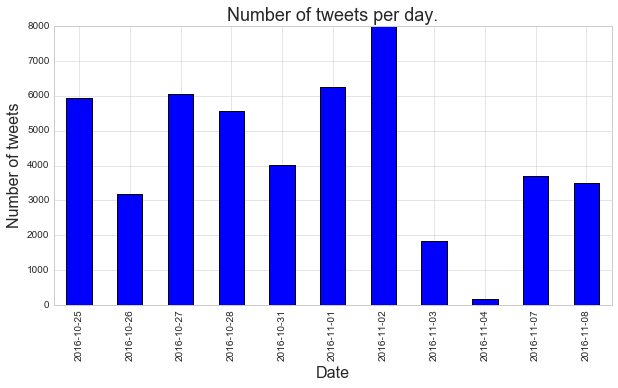

In [864]:
counts = df.groupby("date")["tweet_id"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of tweets", fontsize=16)
plt.title("Number of tweets per day.", fontsize=18);

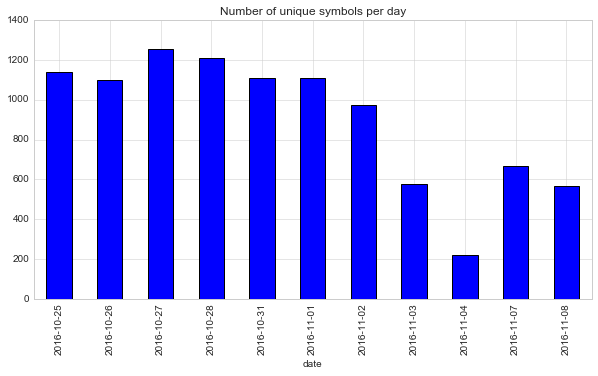

In [865]:
counts = df.groupby("date")["symbol"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", title="Number of unique symbols per day");

In [866]:
#Create a {"date": dataframe} dictionary
dataframes = {}
for date in df["date"].unique():
    dataframes[date] = clean_dataframe(df[df["date"]==date]).reset_index(drop=True)
    
print(dataframes.keys())

dict_keys(['2016-10-26', '2016-11-03', '2016-10-25', '2016-10-31', '2016-10-28', '2016-11-07', '2016-11-08', '2016-10-27', '2016-11-01', '2016-11-02', '2016-11-04'])


In [867]:
df2 = dataframes["2016-10-27"]
df2[["name","date","symbol","time","hour","weekday","title","tweet_id","user_id","user_name"]].head()

,name,date,symbol,time,hour,weekday,title,tweet_id,user_id,user_name
0,Estimize,2016-10-27,ORLY,00:01:49,00:00,3,O'Reilly Automotive Inc.,65617674,727510,EstimizeAlerts
1,Form4Reporter,2016-10-27,JNPR,00:02:12,00:00,3,"Juniper Networks, Inc.",65617689,769927,Form4Reporter
2,Mike,2016-10-27,AAPL,00:07:29,00:00,3,Apple Inc.,65617970,79818,Vikings12
3,Mike,2016-10-27,QQQ,00:07:29,00:00,3,PowerShares Nasdaq-100 QQQ,65617970,79818,Vikings12
4,Tim F,2016-10-27,JNPR,00:07:37,00:00,3,"Juniper Networks, Inc.",65617973,249818,timMN


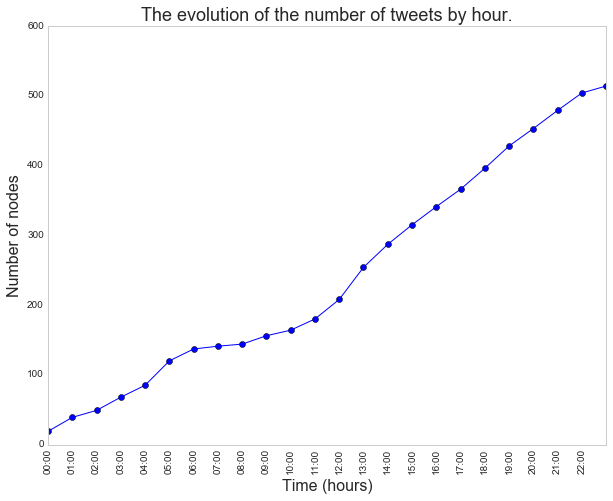

In [868]:
df3 = df2.drop_duplicates(subset=["symbol"], keep="first")
counts = df3.groupby("hour")["tweet_id"].nunique().cumsum()
counts.sort_index(ascending=True, inplace=True)
fig = plt.figure(figsize=(10,7.5))
counts.plot(kind="line", rot=90, marker="o", xticks=range(23), grid=False)
plt.xlabel("Time (hours)", fontsize=16)
plt.ylabel("Number of nodes", fontsize=16)
plt.title("The evolution of the number of tweets by hour.", fontsize=18);

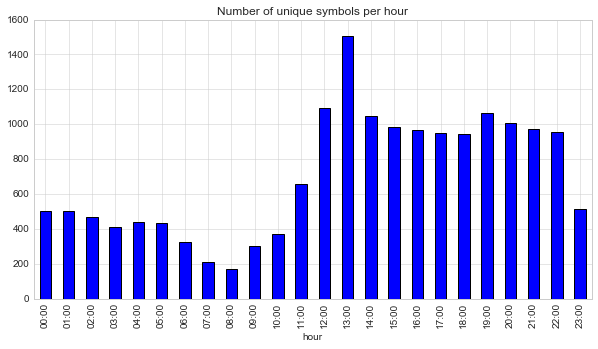

In [869]:
counts = df.groupby("hour")["symbol"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", title="Number of unique symbols per hour");

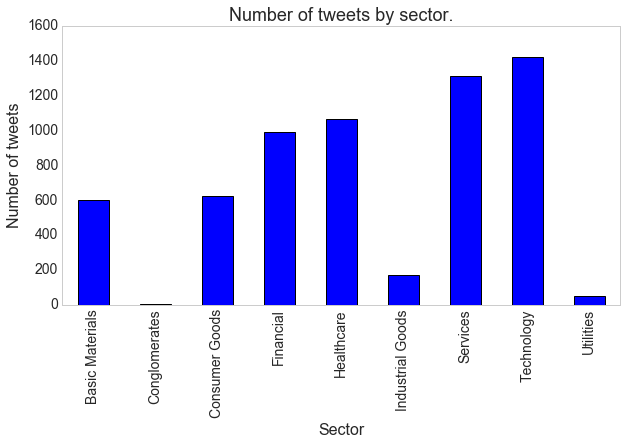

In [870]:
counts = df2.groupby("sector")["tweet_id"].nunique()
counts.sort_index(ascending=True, inplace=True)
counts.plot(kind="bar", fontsize=14, grid=False)
plt.xlabel("Sector", fontsize=16)
plt.ylabel("Number of tweets", fontsize=16)
plt.title("Number of tweets by sector.", fontsize=18);

In [871]:
network = nx.Graph()
network.add_nodes_from(df2["symbol"].values)

#create a dictionary of {tweet_id : [symbols]}
dict1 = {}
rdf = df2.groupby("tweet_id")
for tweet_id in list(set(df2.tweet_id.values)):
    dict1[tweet_id] = list(rdf.get_group(tweet_id).symbol.values) 
    
degree_dynamics = {"CWEI": [], "AAPL": [], "GOOG": [], "AMZN": [], "SPY": []}

#Create and save the weighted graph for use in Gephi
for key, value in dict1.items():
    for tup in list(itertools.combinations(value, 2)):        
        source = tup[0]
        target = tup[1] 
        for key in degree_dynamics.keys():
            degree_dynamics[key].append(network.degree(key))
            
        if source != target:
            if network.has_edge(source, target) == True:            
                network[source][target]["weight"] += 1
            else:
                network.add_edge(source, target, weight=1, key=str(key))

In [872]:
len(degree_dynamics["SPY"])

33642

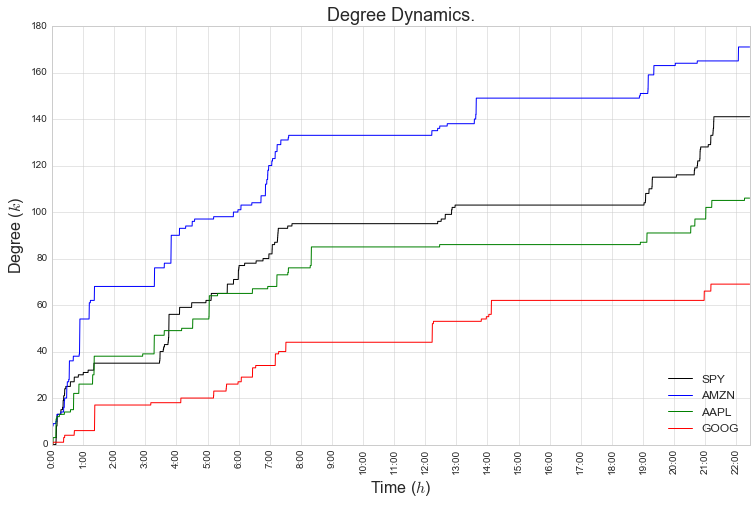

In [873]:
fig = plt.figure(figsize=(12.5,7.5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(np.arange(0, 36000, 1500)) 
ax.set_xticklabels([str(x) + ":00" for x in range(24)], rotation=90)
plt.plot(degree_dynamics["SPY"], color="black", label="SPY")
plt.plot(degree_dynamics["AMZN"], color="blue", label="AMZN")
plt.plot(degree_dynamics["AAPL"], color="green", label="AAPL")
plt.plot(degree_dynamics["GOOG"], color="red", label="GOOG")
plt.xlabel("Time ($h$)", fontsize=16)
plt.ylabel("Degree ($k$)", fontsize=16)
plt.title("Degree Dynamics.", fontsize=18)
plt.legend(loc="lower right");

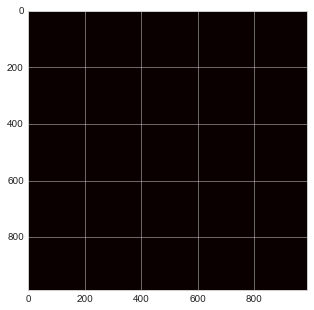

In [874]:
N = len(network.nodes())
matrix = [[0] * N] * N
for i in range(N):
    for j in range(N):
        if network.has_edge(i, j):
            matrix[i][j] = network[i][j]["weight"]
        
plt.imshow(matrix, cmap="hot", interpolation="nearest")
plt.show()

In [875]:
get_network_measures(network)


N : 987 
L : 8044 
Minimum degree : 0 
Maximum degree : 171 
Average degree : 16.2998986829


In [876]:
remove = [(source, target) for source, target in network.edges_iter() if network[source][target]["weight"] < 2]
network.remove_edges_from(remove)

remove = [node for node in network.degree() if network.degree()[node] == 0]
network.remove_nodes_from(remove)

#for source, target in network.edges_iter():
#    network[source][target]["weight"] = 1

In [877]:
get_network_measures(network)


N : 412 
L : 2188 
Minimum degree : 1 
Maximum degree : 70 
Average degree : 10.6213592233


In [878]:
#Add node attributes 
nodes  = []
titles = {}
sectors = {}
degrees = network.degree()

for node in network.nodes():
    titles[node] = df2["title"][df2.symbol==node].values[0]
    sectors[node] = df2["sector"][df2.symbol==node].values[0]
    industry = symbol_title["industry"][symbol_title.symbol==node].values
    nodes.append({"name": node, "title": titles[node], "industry": industry, "degree": degrees[node]})

nx.set_node_attributes(network, "Title", titles)
nx.set_node_attributes(network, "Sector", sectors)
nx.write_gexf(network, "symbol_graph.gexf")

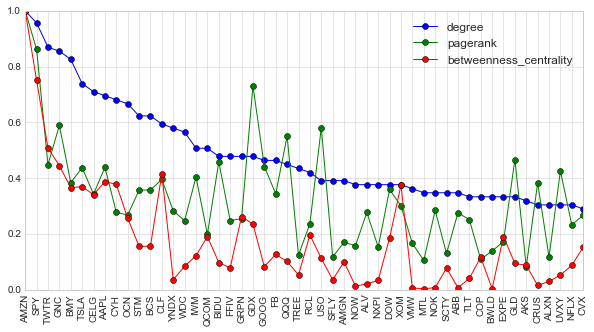

In [879]:
measures  = pd.DataFrame(index=network.nodes())
page_ranks = nx.pagerank(network)
btwns_clty = nx.betweenness_centrality(network)

measures["degree"] = [degrees[node] for node in measures.index]
measures["pagerank"] = [page_ranks[node] for node in measures.index]
measures["betweenness_centrality"] = [btwns_clty[node] for node in measures.index]

scaler = preprocessing.MinMaxScaler()
measures[["degree","pagerank","betweenness_centrality"]] = scaler.fit_transform(measures)
measures.sort_values(["degree"], ascending=False, inplace=True)
measures[0:50].plot(kind="line", rot=90, marker="o", xticks=range(50));

In [880]:
mst = nx.minimum_spanning_tree(network, "weight")
nx.write_gexf(mst, "mst_symbol_graph.gexf")

In [881]:
#save the unweighted graph for use in R
data = []
node_list = list(network.nodes())

for (source, target) in network.edges():
    data.append({"value": 1.0, 
                 "id": network[source][target]["key"],
                 "source": node_list.index(source), 
                 "target": node_list.index(target)
                })    

links = pd.DataFrame(data)
nodes = pd.DataFrame(nodes)
links.to_csv("Rlinks.csv", index=False, encoding="utf-8")
nodes.to_csv("Rnodes.csv", index=False, encoding="utf-8")

In [882]:
values = list(degrees.values())

In [883]:
def distribution(data):
    degrees = {}
    for n in data:
        if n not in degrees:
            degrees[n] = 0
        degrees[n] += 1
    return sorted(degrees.items())

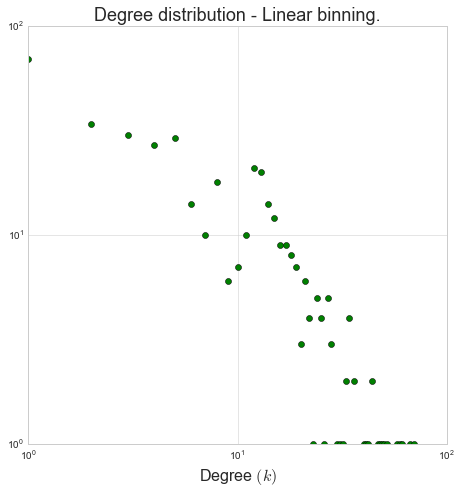

In [884]:
fig = plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(111)
data = distribution(values)
ax.loglog([k for (k ,v) in data], [v for (k, v) in data], "go")
plt.xlabel(r"Degree $(k)$", fontsize=16)
plt.title(r"Degree distribution - Linear binning.", fontsize=18)
plt.show()

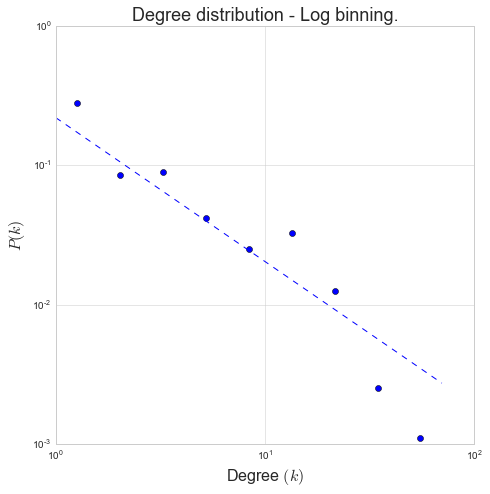

In [885]:
fig = plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(111)
ax = log_binning_plot(ax, values, "b")
plt.xlabel(r"Degree $(k)$", fontsize=16)
plt.title(r"Degree distribution - Log binning.", fontsize=18)
fitted = powerlaw.Fit(values, xmin=min(values), xmax=max(values), discrete=True)
fitted.power_law.plot_pdf(color="b", linestyle="--", ax=ax);

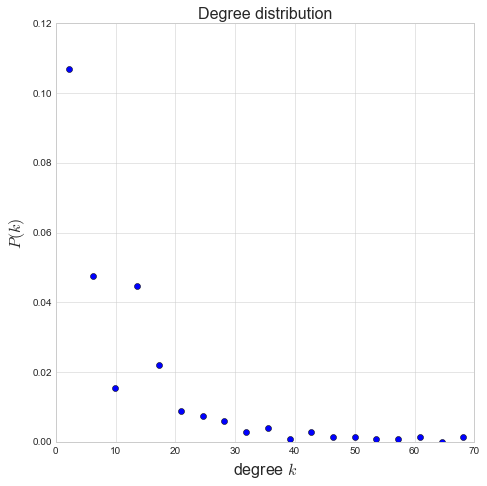

In [886]:
log_linear_plot(values)

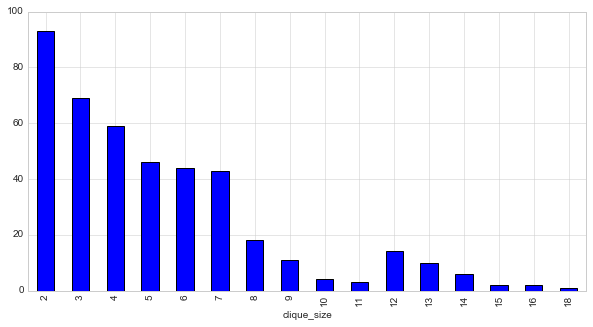

In [887]:
clique_size = pd.DataFrame([{"clique_size": len(x)} for x in nx.find_cliques(network)])
clique_size.groupby("clique_size")["clique_size"].count().plot(kind="bar");

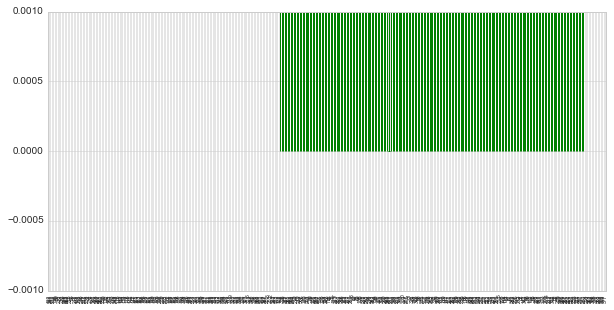

In [888]:
def similarity_matrix(G):
    #return an n x n array representing the similarity matrix of G
    n = len(G)
    k = list(G.degree().values())
    A = nx.adjacency_matrix(G)    
    #A^2 is number of common neighbors, plus A gives one for being connected
    J = A@A + A
    X = np.zeros((n, n))
    for i, j in itertools.product(range(len(G.nodes())), repeat=2):
        X[i,j] = J[i,j]/(min(k[i], k[j]) + 1 - A[i,j])
    return X

giant_component = max(nx.connected_component_subgraphs(network), key=len)
X = similarity_matrix(giant_component)
Z = hierarchy.linkage(X)
result = hierarchy.dendrogram(Z)

In [889]:
len(giant_component)

378